<h1 class="text-center">BCI - Decoding frequency-tagging: a SSVEP-based BCI</h1>
<h2 class="text-center">February, 2022</h2>

<br>

The purpose of this tutorial is to implement a reactive BCI using SSVEP on a dataset collected in our laboratory. You will use MNE to load and pre-process the data and Sklearn+MNE for the classification part. 
</b></div>

- In Section I, exploration data analysis, frequency analysis and epoching using MNE
- In Section II, a first classifier is trained on SNR at stimulation frequencies
- In Section III, another pipeline that uses Canonical Correlation Analysis with sinus templates to learn a spatial filter.
- In Section IV, a more advance pipeline based on Task Related Correlation Analysis that add individual templates from calibration data and temporal filterbank to CCA pipeline.
- The last section (V) explores more comfortable stimulation for SSVEP-based BCI (lower amplitude)

The code must be completed after each **Question** to work, where "HERE" appears as a comment in the code. The parameters that do not change the course of the story are accompanied "EDIT ME!" as a comment: you can change them at the time or at the end of the section to see the changes involved.

In [7]:
import mne
import os

import matplotlib.pyplot as plt

import numpy as np

from scipy.stats import ttest_rel

# I - Dataset exploration and pre-processing
In this session we will work with data acquired at ISAE-SUPAERO on Steady States Visually Evoked Potentials (SSVEP). EEG data was collected using 32 Ag/AgCl active electrodes. A 32-channel montage based on the international 10-20 system was used to record the EEG signals with a sampling rate of 500Hz. The EEG device used in this experiment was the Brain Products LiveAmp system. Brain data was recorded using the LabRecorder software and the experimental protocol was implemented using the Psychopy Python library. Events from the experimental paradigm were synchronized with the EEG signal recording using the Lab Streaming Layer (LSL) library.

**The subjects were asked to look at four different stimuli with rectangular shapes**. These stimuli flickered at different frequencies. Because of this difference in frequency, each stimuli elicits a different response in the Primary Visual Cortex, that we can classify in order to know at which target the participants were looking at each trial.

## We load the data and plot the sensor location
The data is presented in [EEGLAB .set format](https://eeglab.org/tutorials/03_Dataset_management/datasets.html). MNE supports data-loading functions in most common file formats in their `mne.io` module, check [here](https://mne.tools/0.18/manual/io.html#id15) for a complete list and link to the corresponding functions.

In [8]:
## This cell will be deleted / repurposed when we decide how the students will get access to the data (I don't want to put it on the repo)
data_dir = '/home/hororo/data/eeg_ssvep'
data_file = 'P1_highamp.set'

/tmp/ipykernel_4808/3892261847.py:3: RuntimeWarning: Data file name in EEG.data (P1_highamp2.fdt) is incorrect, the file name must have changed on disk, using the correct file name (P1_highamp.fdt).
  raw_data = mne.io.read_raw_eeglab(data_path, preload=True, verbose=False)


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 32 items (32 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 500.0 Hz
>


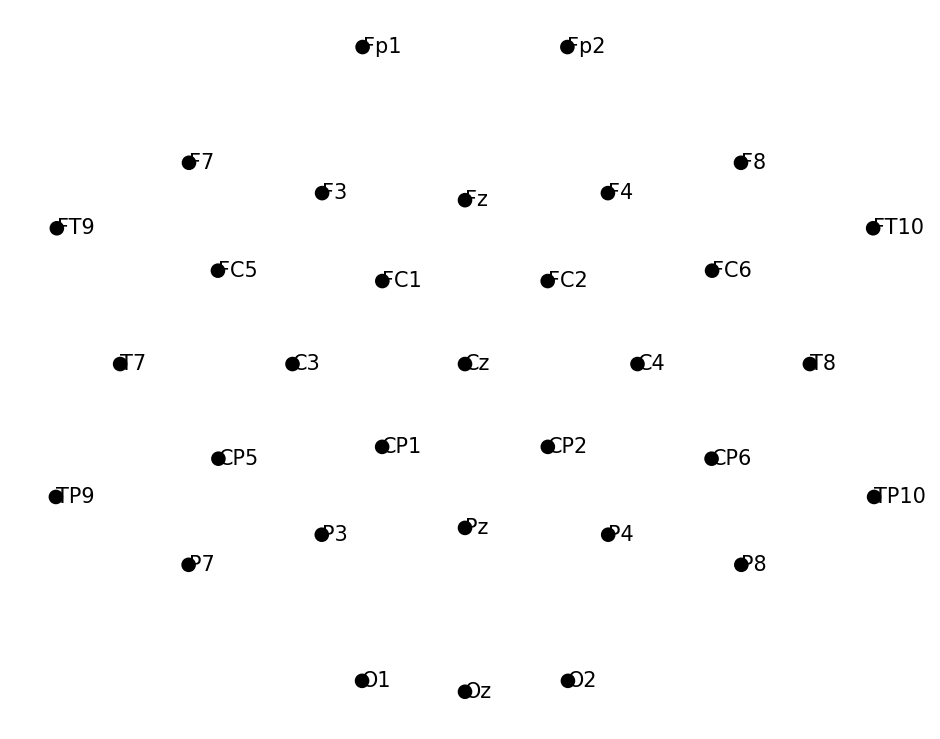

(32, 760607)

In [19]:
# Load data
data_path = os.path.join(data_dir, data_file)
raw_data = mne.io.read_raw_eeglab(data_path, preload=True, verbose=False)

# Show info (dict containing relevant metadata)
print(raw_data.info)

# Display the montage (sensors on the scalp)
plt.rcParams['figure.dpi'] = 150
raw_data.plot_sensors(ch_type='eeg',show_names=True)

## Now let us explore the EEG data.
As previously, the data array has a shape of (channels, time). We use the `get_data()` method to obtain the EEG array.

In [27]:
data_array = raw_data.get_data()

# Print the shape of the data
print(data_array.shape)

(32, 760607)


As previously stated, this data was acquired using a sampling frequency of 500Hz. We can recover this parameter from the `info` structure. This will be useful as we progress, but for now let's find out how long our data is in seconds.

In [30]:
sfreq = raw_data.info['sfreq']
seconds = data_array.shape[-1] // sfreq
print(f'Data duration in seconds: {seconds} (around {seconds // 60} minutes)')

Data duration in seconds: 1521.0 (around 25.0 minutes)


Data can be conveniently plotted from the raw object directly, allowing us some handy operations like filtering the data before displaying

Setting up band-pass filter from 2 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 2.00, 200.00 Hz: -6.02, -6.02 dB

Opening raw-browser...


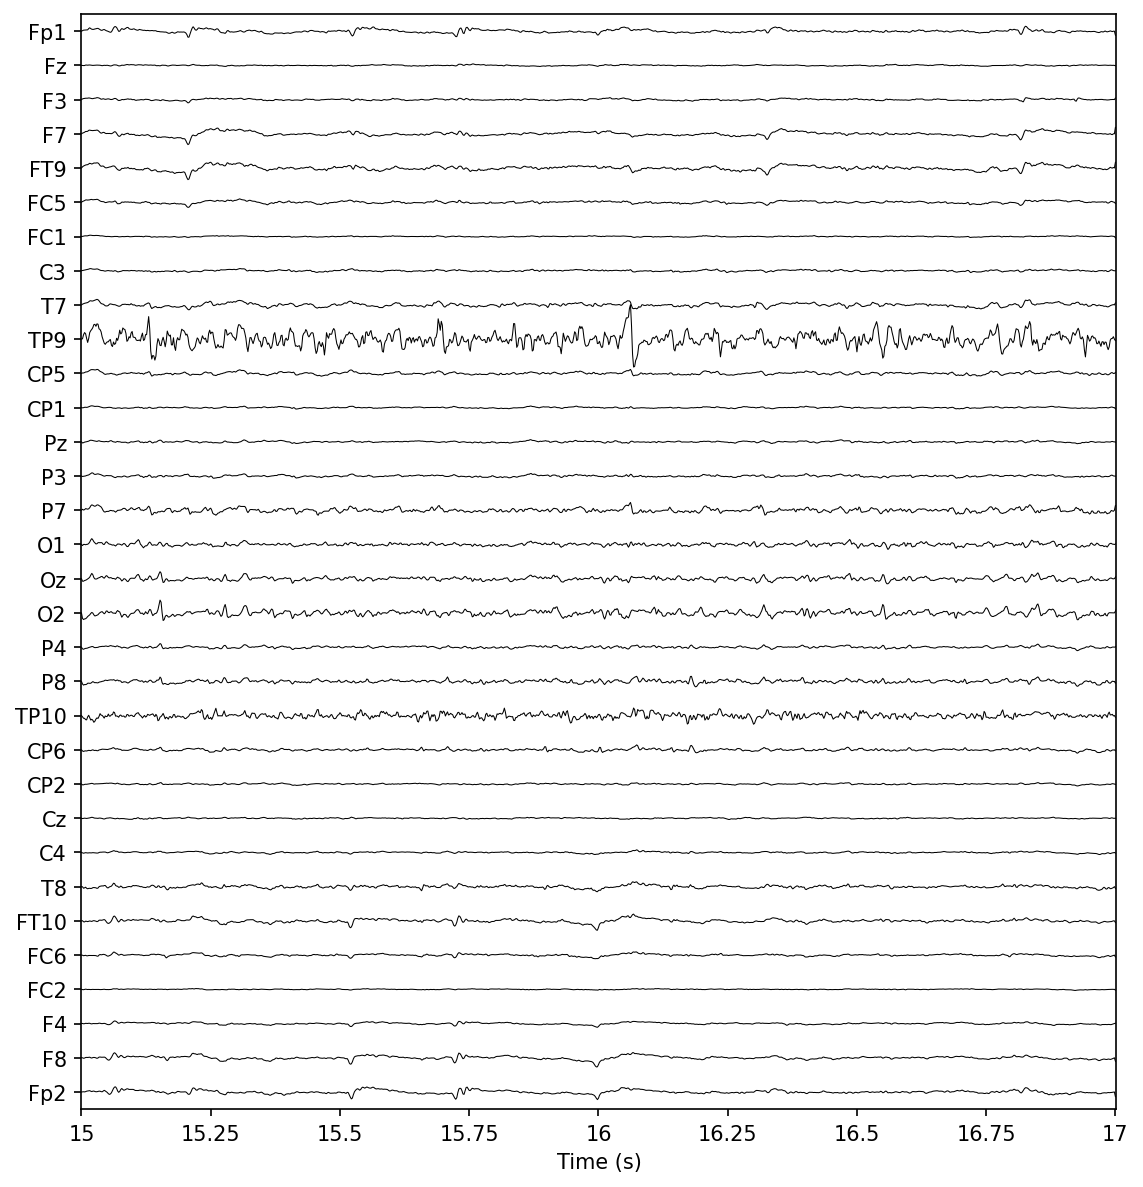

In [35]:
plt.rcParams['figure.dpi'] = 150
scal = dict(eeg=1e-4)                      # EDIT ME!
raw_data.plot(n_channels=32, scalings=scal,
              start=15, duration=2,             # EDIT ME!
              lowpass=200, highpass=2,          # EDIT ME!
              show_scrollbars=False, show_scalebars=False)
plt.show()

### Let's explore some of the events
In this case, we find the events on an annotation file. Several ways of storing events exist, please refer to [the MNE documentation](https://mne.tools/dev/auto_tutorials/raw/20_event_arrays.html) to learn more about how to interact with different types of events. Here, we use the `events_from_annotations()` function to load them.

In [50]:
# Annotations are part of the raw object
print(raw_data.annotations)
print()

# We load the events and the event_id
events, event_id = mne.events_from_annotations(raw_data, verbose=False)

# event_id is a dictionary that related each label to their event name
print(event_id)
print()

# The events are a list where each element is a 3-element list. The first element is the onset of the event, and the last one is the label according to event_id
print(events[:10])

<Annotations | 120 segments: 13.33Hz, phase 0 (30), 17.14Hz, phase 0 (30), ...>

{'13.33Hz, phase 0': 1, '17.14Hz, phase 0': 2, '21.82Hz, phase 0': 3, '24.0Hz, phase 0': 4}

[[36467     0     2]
 [39467     0     2]
 [45468     0     2]
 [51468     0     2]
 [66469     0     2]
 [75470     0     4]
 [84471     0     4]
 [93471     0     4]
 [96472     0     1]
 [99472     0     3]]


Opening raw-browser...


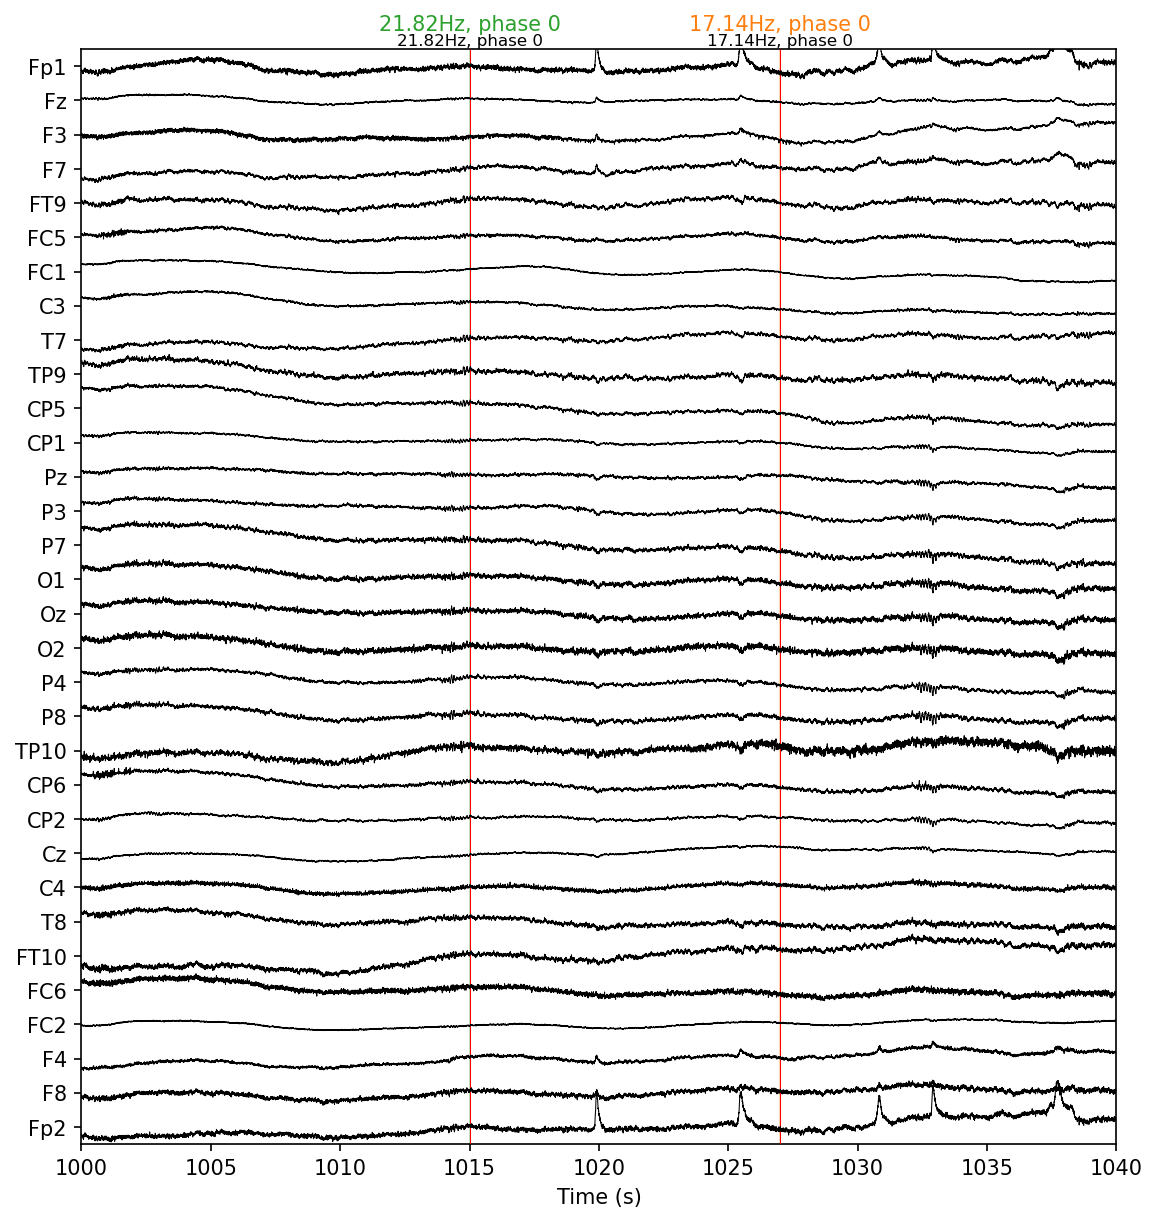

In [58]:
# Display EEG signal with some events
scal = dict(eeg=1e-4)     # EDIT ME!
plt.rcParams['figure.dpi'] = 150
raw_data.plot(events=events, event_color='red', event_id=event_id,
              scalings=scal, clipping=None, show_scrollbars=False, show_scalebars=False, 
              start=1000, duration=40,  # EDIT ME!
              n_channels=32)
plt.show()

## Preprocessing Pipeline
We do not see a lot going on, for that we will have to move to the **frequency domain**, where we will be able to see and capture differences in frequency. Before that, we will have to pre-process the data. Different analysis require different pre-processing pipelines, and this time we will:

- Keep the relevant channels
- Band-pass filter the data
- Epoch the data

The only step that is new to this analysis is to keep a selection of channels. We will see an example first.

In [65]:
# To keep a selection of channels, first select the channels we want to keep
ch_to_keep = ["Fp1", "Fp2"]

# Make a list of the channels to drop
ch_to_drop = list(set(raw_data.ch_names) - set(ch_to_keep))
print(ch_to_drop)  # All the channels except ch_to_keep

# Drop the rest of the channels using the drop_channels() function
raw_data = raw_data.drop_channels(ch_to_drop)

[]


**Question**: Load, pre-process, and epoch the data of a different subject using the functions presented until now. 

- Keep all the channels on the occipital (O) and parieto-occipital (PO) area
- Keep in mind the frequency of the stimuli for filtering (i.e., make sure to capture all the stimulation frequencies)
- Epoch between 0 and 2s, with a baseline of (0.2, 2)

In [ ]:
# Load the data 
question_file = 'P5_highamp.set'

data_path = os.path.join(data_dir, data_file)
raw_data = mne.io.read_raw_eeglab(data_path, preload=True, verbose=False)  # HERE

# Get events and event_id
events, event_id = mne.events_from_annotations(raw, verbose=False)  # HERE

# Drop all channels except selection
ch_to_keep = ["PO7", "PO3", "POz", "PO4", "PO8", "O1", "Oz", "O2"]  # HERE
ch_to_drop = list(set(raw_data.ch_names) - set(ch_to_keep))  # HERE

raw_data = raw_data.drop_channels(ch_to_drop)  # HERE

# Filter the data
raw = raw.filter(l_freq=3, h_freq=30, method="iir", verbose=False)  # HERE

# Epoch the data
epochs = mne.Epochs(raw, events, event_id=event_id,  # HERE
                    tmin=0, tmax=2, baseline=(0.2, 2),
                    preload=True, verbose=False)

#### Hints: Functions to use. Open if you need a reminder of the functions necessary for the avobe exercise

- load data: `mne.io.read_raw_eeglab`
- find events: `mne.events_from_annotations`
- drop channels: `raw_data.drop_channels`
- filter: `raw_data.filter`
- epoch: `mne.Epochs`

#### Additional hints: Check if you feel lost

- You can check the signature of any function (how to call it, arguments, documentation, etc.) adding a '?' after its name in a jupyter notebook cell, for example, try running `mne.events_from_annotations?` on a new cell
- You can check the list of all EEG channels in `raw_data.info['ch_names']`
- You can check the stimulation frequencies with the `event_id` dictionary.